## CS 5963 Project Milestone

# New York City Schools Survey

## **Group Members**  

Kara Johnson (u0409733) - E-mail: kjohnson@sci.utah.edu   
Sara Johnson (u0884127) - E-mail: sara.l.johnson@utah.edu

### Background and Motivation

Education is an important pillar in our society today. Especially in the past few years, education has become an important topic in news and politics with a rise in the public's general dissatisfaction with schools' educational quality and environment. The goal of this project was to identify the educational and environmental factors that contribute to overall parent and student satisfaction with high schools. We used New York City as a model, as it has over 400 high schools and has made data from their annual school survey available for analysis. This survey collects parent and student responses to a number of questions pertaining to aspects of education and school environment. We investigated which of these aspects are most important to students and which aspects are most important to parents. 

We were also interested in investigating whether demographic, socioeconomic status, or geographic location can be predicted using these educational aspects.  We will incorporate demographic statistics about the schools and build classification models using these variables to test if the aspects important to students are better predictors for schools' percent minority, percent poverty, or geographic location. The conclusions of this project could shed light on what factors that schools with low percent satisfaction should focus on in order to improve their student and parent perceptions.

### Project Objectives

**Objective 1.** We investigated which educational aspects from the NYC Schools Survey are most important to students and which aspects are most important to parents.   
   
**Objective 2.** We incorporated demographic, socioeconomic, and geographic data on the high schools and used the important aspects identified in Objective 1 to build the following classification models:
- Classification of 'Percent Minority', 'Percent Poverty', and 'Borough' using the aspects important to parents
- Classification of 'Percent Minority', 'Percent Poverty', and 'Borough' using the aspects important to students   
   
We then made comparisons of the classification models' accuracies to draw conclusions on factors important to overall satisfaction and their ability to predict the demographic and socioeconomic landscape as well as the borough of the school.   
   
**Objective 3.** We created a classification model to classify the whether the schools had a small or large difference in their overall parent versus student satisfaction. In this classification model, we used the educational aspects that were most correlated with the percent difference of parent and student satisfaction.

### Data

We collected and combined three datasets: 
1. 2016 New York City School Survey -- collects student and parent responses to surveys about their school,   
2. High Schools At A Glance -- includes information about high school programs, Advanced Placement (AP) courses, and career training programs,   
3. Demographic Snapshot -- demographic information including total enrollment, gender ratios, and race percentages at the city, borough, district, and school-level.   

These datasets are available online in Excel spreadsheet format.

2016 New York City School Survey: http://schools.nyc.gov/Accountability/tools/survey/default.htm   
High Schools At a Glance: http://schools.nyc.gov/ChoicesEnrollment/High/Resources/default.htm
Demographic Snapshot: http://schools.nyc.gov/NR/rdonlyres/46093164-D8AA-40DD-A400-8F80CEBC8DD5/0/DemographicSnapshot201112to201516Public_FINAL.xlsx

### Data Processing

For the survey dataset, we selected a number of variables that we were interested in. These include:
- Parent response rate
- % Satisfaction with 'Collaborative Teachers'
- % Satisfaction with 'School Leadership'
- % Satisfaction with 'Rigorous Instruction'
- % Satisfaction with 'Family-Community Ties'
- % Satisfaction with 'Supportive Environment'
- % Satisfaction with 'Trust'
- % Overall Parent Satisfaction
- % Overall Student Satisfaction

We also removed all schools that do not correlate with the "High School At a Glance" dataset. This was performed by matching the school's unique DBN number provided in both datasets.   

We also extracted other variables from the "High School At a Glance" dataset that we will use for performing our analysis. These include:
- Borough
- Number of Programs
- Neighborhood
- Graduation Rate 
- Attendance Rate
- % Students who feel safe
- AP Courses 
- CTE Programs

AP Courses and CTE Programs categories were converted into a binary value: 1 for offered, 0 for not offered.    

For the Demographics dataset, we extracted the following columns at the citywide, borough, district, and school-level:   
- Total enrollment
- % Female, % Male
- % Asian, Black, Hispanic, Other, or White
- % Poverty

We also had to filter out the rows to extract only the data from the 2015-2016 school year. Additionally, we decided to sum the '% Asian, % Black, % Hispanic, and % Other' to create a column of '% Minority' and use this instead for our analysis.

#### 1. Import data

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])

import scipy as sc
from scipy.stats import linregress
from scipy.stats import norm

import statsmodels.formula.api as sm


#NYC School Survery Import (HSS): 
RespRate = pd.read_excel("2016 NYC School Survey Public Data.xlsx",sheetname = 0)

#High Schools At a Glance Import (HSAAG): 
schools = pd.read_csv('HSAAG_data/HSAAG_Schools.csv', encoding='latin-1',header=0)

#Demographics:
dem_school = pd.read_excel("DemographicSnapshot201112to201516Public_FINAL.xlsx",sheetname=3)



#### 2. Clean data and keep/rename columns of interest

In [2]:
# 1.
### CLEAN DATA ####

# HSAAG - Keep columns of interest
schools = pd.read_csv('HSAAG_data/HSAAG_Schools.csv', encoding='latin-1',header=0)
schools.columns = ['rmv','School Name', 'DBN','Borough','Number of Programs','rmv2','rmv3', 'Neighborhood',
                   'Graduation Rate','Attendance Rate', '% students who feel safe','AP Courses y/n',
                   'rmv7', 'CTE y/n','rmv4', 'rmv5', 'rmv6']
school_cols = ['DBN', 'Borough', 'Number of Programs','Neighborhood', 'Graduation Rate', 
               'Attendance Rate','% students who feel safe', 'AP Courses y/n','CTE y/n']

schoolsDF = schools[school_cols]

# HSAAG - Change 'Graduation Rate', 'Attendance Rate', and '% students who feel safe' to decimals
schoolsDF['Graduation Rate'] = schoolsDF['Graduation Rate'].str.replace('%','').astype(float).apply(lambda x: x/100);
schoolsDF['Attendance Rate'] = schoolsDF['Attendance Rate'].str.replace('%','').astype(float).apply(lambda x: x/100);
schoolsDF['% students who feel safe'] = schoolsDF['% students who feel safe'].str.replace('%','').astype(float).apply(lambda x: x/100);

# HSAAG - Change Yes to 1. NaNs in this dataset correspond to 'No', so set NaNs to 0
# Index to DBN for easy comparison and merging of dataframes
schoolsDF = schoolsDF.fillna(0).replace('Yes',1).set_index('DBN')

# HSS - Keep columns of interest
RespRate.columns = ['DBN','School Name', 'Parent RR','Teacher RR','Student RR','Collab. Teachers','School Leadership',
                   'Rig. Instruction','Fam-Community Ties', 'Supportive Envment.','Trust','Parent PS',
                   'Student PS', 'Teacher PS']
RespRate_cols = ['DBN','Parent RR','Collab. Teachers','School Leadership','Rig. Instruction','Fam-Community Ties', 
                 'Supportive Envment.','Trust','Parent PS','Student PS']
schools2 = RespRate[RespRate_cols]

# Demographics - Keep columns of interest
dem_school_cols = ['DBN','Year', 'Total Enrollment','% Female','% Male','% Asian', '% Black', '% Hispanic','% Other',
                   '% White','% Students with Disabilities', '% Poverty']
demog = dem_school[dem_school_cols]

# Demographics - keep data from 2015-2016 school year
demo_rec = demog[demog['Year'] == '2015-16']
demog_cols = ['DBN','Total Enrollment','% Female','% Male','% Asian', '% Black', '% Hispanic','% Other',
                   '% White','% Students with Disabilities', '% Poverty']
demog = demo_rec[demog_cols]
# Demographics - combine minorities into single column
minorities = ['% Asian','% Black','% Hispanic','% Other']
demog['% Minority'] = demog[minorities].sum(axis=1)
demog_cols2 = ['DBN','Total Enrollment','% Female','% Male','% White','% Minority','% Poverty']
demog2 = demog[demog_cols2]

# Combine HSAAG and HSS by joining with School DBN as index 
schools_HS = schoolsDF.join(schools2.set_index('DBN'),how = 'inner')
schoolsN = schools_HS.join(demog2.set_index('DBN'), how = 'inner')

# Convert all non-strings to floats for easier processing 
schoolsN = schoolsN.apply(lambda x: pd.to_numeric(x,errors='ignore')).fillna(0)

#Rename the columns for easier referencing 
schoolsN.columns = ['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate', 'AttendanceRate', 
         'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR', 'Collab_Teachers', 'School_Leadership',
         'Rig_Instruction', 'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS', 
         'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale','PerWhite', 'PerMinority','PerPoverty']

/Users/karajohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/karajohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/karajohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [3]:
#2. 
### CLEAN DATA ##### 

#Determine if there are "0" values in the survey results 
investigate = ['ParentRR', 'Collab_Teachers', 'School_Leadership','Rig_Instruction', 'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS', 
         'StudentPS', 'TotalEnrollment']

schoolsT = schoolsN[investigate]
Idx = []
Col = []
Value = []
test = schoolsT.iterrows()

for index,row in schoolsT.iterrows(): 
    for col in schoolsT.columns.tolist():
        if schoolsT.loc[index,col] == 0:
            Idx.append(index)
            Col.append(col)
            Value.append(schoolsT.loc[index,col])        
Zeros = pd.DataFrame({'Row':Idx,'Column':Col,'Value':Value})
Zeros = Zeros[['Row','Column','Value']] 
print('Cells with 0-value: ')
Zeros

Cells with 0-value: 


,Row,Column,Value
0,05M367,ParentPS,0.0
1,12X479,ParentPS,0.0


Since two schools are missing data for the ParentPS category, we will remove these schools from the analysis below.

In [4]:
#3.
### CLEAN DATA ####

#filter out schools w/o Parent PS data 
schoolsN = schoolsN[schoolsN['ParentPS'] > 0]
print(schoolsN.shape)

#Add a column which is the difference in Parent and Student Satisfaction rate for all schools
schoolsN['ParentStudentPS_Diff'] = schoolsN['ParentPS'] - schoolsN['StudentPS'] 


(436, 23)


### Exploratory Data Analysis

We first wanted to characterize the schools by the NYC borough they were located in (Brooklyn, the Bronx, Manhatten, Queens, and Statten Island) to determine if there are any clear trends with geography, or if any borough stands out from the rest.

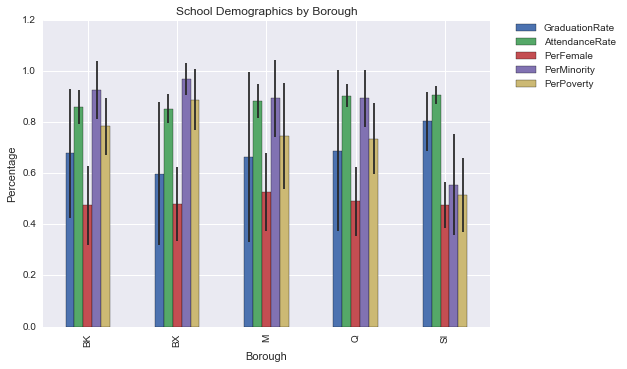

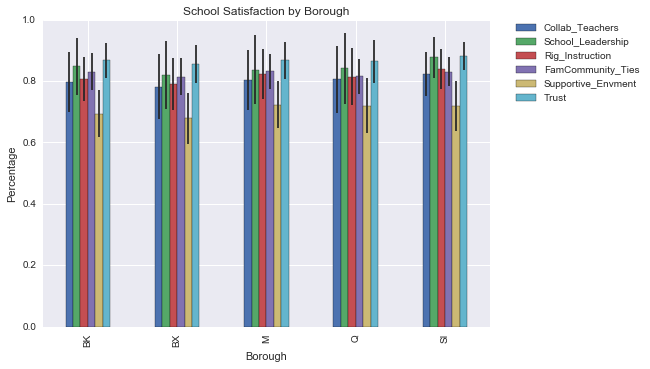

In [5]:
import seaborn as sns
sns.set()

dfplt1 = schoolsN[[0,3,4,18,21,22]]
dfplt2 = schoolsN[[0,9,10,11,12,13,14]]

Borough_means = dfplt1.groupby('Borough').mean()
Borough_std = dfplt1.groupby('Borough').std()
Borough_means.plot.bar(yerr=Borough_std)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Percentage')
plt.title('School Demographics by Borough') 

Borough_means = dfplt2.groupby('Borough').mean()
Borough_std = dfplt2.groupby('Borough').std()
Borough_means.plot.bar(yerr=Borough_std)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Percentage')
plt.title('School Satisfaction by Borough') 

**Borough Demographics** There is less variability between boroughs in attendance rate and percent female than in the other demographic qualities. Statten Island has notably lower percentages of minorities and students living in poverty than the other four boroughs. Additionally, Statten Island has the highest graduation rate. However, the remaining boroughs are relatively similar in these three demographic variables.    
   
**Borough Survey Responses** In contrast to the demographic data, there is little variation in the average percent satisfaction (PS) in six survey categories. However, PS in "Supportive Environment" is significantly lower than the other categories in all boroughs.   
   
Next, we plot Student and Parent overall satisfaction against attendance and graduation rate. To simultaneously investigate a dependence on school size, we sized the data points proportionally to Enrollment.

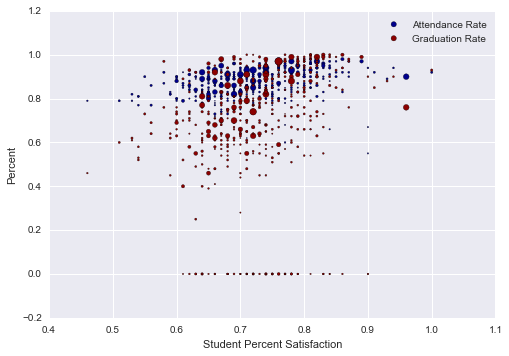

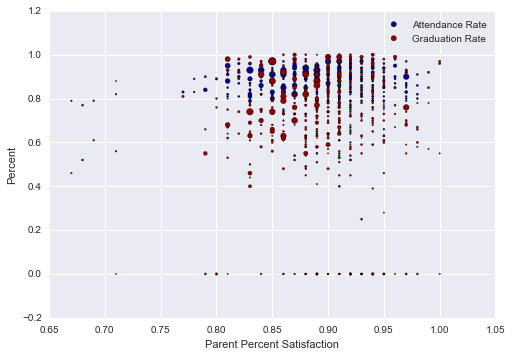

In [6]:
# scatter plot of poverty with school statistics 
ax = schoolsN.plot.scatter(x='StudentPS', y='AttendanceRate', color='DarkBlue', label='Attendance Rate',s=schoolsN['TotalEnrollment']*.01);
schoolsN.plot.scatter(x='StudentPS', y='GraduationRate', color='DarkRed', label='Graduation Rate',s=schoolsN['TotalEnrollment']*.01,ax=ax);
plt.ylabel('Percent') 
plt.xlabel('Student Percent Satisfaction')

ax = schoolsN.plot.scatter(x='ParentPS', y='AttendanceRate', color='DarkBlue', label='Attendance Rate',s=schoolsN['TotalEnrollment']*.01);
schoolsN.plot.scatter(x='ParentPS', y='GraduationRate', color='DarkRed', label='Graduation Rate',s=schoolsN['TotalEnrollment']*.01,ax=ax);
plt.ylabel('Percent') 
plt.xlabel('Parent Percent Satisfaction') 

Overall Parent satisfaction with the school (Parent PS) is uncorrelated with graduation rate (correlation is < 0.2), while overall Student satisfaction is positively correlated with both attendance and graduation rate. 
   
Additionally, we wanted to visualize the distributions of Parent Response Rate, Parent Percent Satisfaction, and Student Percent Satisfaction.

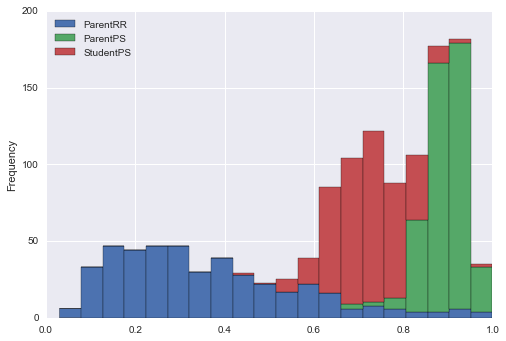

In [7]:
dfplt = schoolsN[['ParentRR','ParentPS','StudentPS']]
plt.figure();
dfplt.plot.hist(stacked=True, bins=20);

The histograms show that there is a very broad distribution of parent response rate (ParentRR). Additionally, the distribution of student percent satisfaction (StudentPS) is broader than that of the parent percent satisfaction (ParentPS). There appears to be a difference in student and parent satisfaction with their schools.

#### Correlation Matrix of Dataframe Columns

Using our combined dataframe, we generated a correlation matrix sorted by low, medium, and high correlations to identify any promising relationships between variables. 

In [8]:
#results = results.where(abs(results) > .4)

results = schoolsN.corr()

Var1 = []
Var2 = []
Correlation = []
for index,row in results.iterrows(): 
    for col in results.columns.tolist():
        if (abs(results.loc[index,col]) >= .2) & (abs(results.loc[index,col]) < .4): 
            Var1.append(index)
            Var2.append(col)
            Correlation.append(results.loc[index,col])        
LowCor = pd.DataFrame({'Var1':Var1,'Var2':Var2,'Correlation':Correlation})
LowCor = LowCor[['Var1','Var2','Correlation']] 
print('Variables with Low Correlation: ')
LowCor2 = LowCor[(LowCor['Var1'] == 'ParentRR') | (LowCor['Var1'] == 'ParentPS') | 
                 (LowCor['Var1'] == 'StudentPS') | (LowCor['Var1'] == 'ParentStudentPS_Diff')]
print(LowCor2)

Var1 = []
Var2 = []
Correlation = []
#print(schoolsN[cols3].corr())
#results.columns.tolist()
for index,row in results.iterrows(): 
    for col in results.columns.tolist():
        if (abs(results.loc[index,col]) >= .4) & (abs(results.loc[index,col]) < .6): 
            Var1.append(index)
            Var2.append(col)
            Correlation.append(results.loc[index,col])
            
MedCor = pd.DataFrame({'Var1':Var1,'Var2':Var2,'Correlation':Correlation})
MedCor = MedCor[['Var1','Var2','Correlation']] 
print('Variables with Medium Correlation: ')
MedCor2 = MedCor[(MedCor['Var1'] == 'ParentRR') | (MedCor['Var1'] == 'ParentPS') | 
                 (MedCor['Var1'] == 'StudentPS') | (MedCor['Var1'] == 'ParentStudentPS_Diff')]
print(MedCor2)

Var1 = []
Var2 = []
Correlation = []
for index,row in results.iterrows(): 
    for col in results.columns.tolist():
        if (abs(results.loc[index,col]) >= .6) & (abs(results.loc[index,col]) < 1): 
            Var1.append(index)
            Var2.append(col)
            Correlation.append(results.loc[index,col])
            
HighCor = pd.DataFrame({'Var1':Var1,'Var2':Var2,'Correlation':Correlation})
HighCor = HighCor[['Var1','Var2','Correlation']] 
print('Variables with High Correlation: ')
HighCor2 = HighCor[(HighCor['Var1'] == 'ParentRR') | (HighCor['Var1'] == 'ParentPS') 
                   | (HighCor['Var1'] == 'StudentPS') | (HighCor['Var1'] == 'ParentStudentPS_Diff')]
print(HighCor2)


Variables with Low Correlation: 
                    Var1                  Var2  Correlation
31              ParentRR       PerStudentsSafe     0.265277
32              ParentRR       Collab_Teachers     0.295202
33              ParentRR     School_Leadership     0.278125
34              ParentRR       Rig_Instruction     0.316165
35              ParentRR     FamCommunity_Ties     0.377738
36              ParentRR                 Trust     0.289130
37              ParentRR              ParentPS     0.316685
38              ParentRR  ParentStudentPS_Diff    -0.306353
64              ParentPS       PerStudentsSafe     0.291677
65              ParentPS              ParentRR     0.316685
66              ParentPS       Collab_Teachers     0.312279
67              ParentPS       Rig_Instruction     0.325689
68             StudentPS        AttendanceRate     0.293740
93  ParentStudentPS_Diff        AttendanceRate    -0.306642
94  ParentStudentPS_Diff              ParentRR    -0.306353
95  Par

The above correlation table shows that the top correlations are:
1. Student Percent Satisfaction + Supportive Environment
2. Student Percent Satisfaction + Rigorous Instruction
4. Student Percent Satisfaction + Trust
5. Student Percent Satisfaction + Collaborative Teachers

These variables will be used to test out multilinear regression models to see which of these (if any or all) contribute the most to percent satisfaction.

Additionally, we are interested in the variables that have top correlation to parent satisfaction:
1. Parent Percent Satisfaction + Familly-Community Ties 
2. Parent Percent Satisfaction + Supportive Environment
3. Parent Percent Satisfaction + Trust   
   
Finally, three variables, Percent of Students Who Feel Safe, Rigorous Instruction, and Supportive Environment, are correlated with the gap between Parent and Student PS. The negative correlations indicate that as the gap in overall satisfaction increases, the percent satisfaction in Supportive Environment decreases. 

#### 2. Box plots and histograms of demographic and socioeconomic distributions

We also calculated descriptive statistics of the variables to (1) make sure that the values are reasonable and (2) identify any interesting attributes. Additionally, we generated box plots and histograms of the percent minority and percent poverty to visualize their distributions.

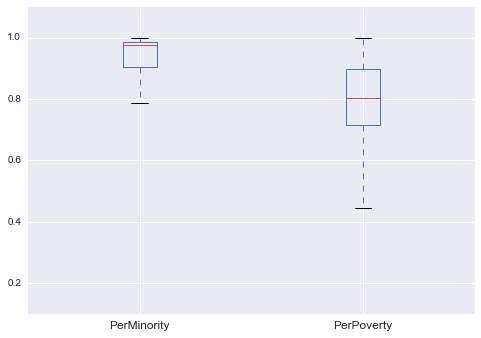

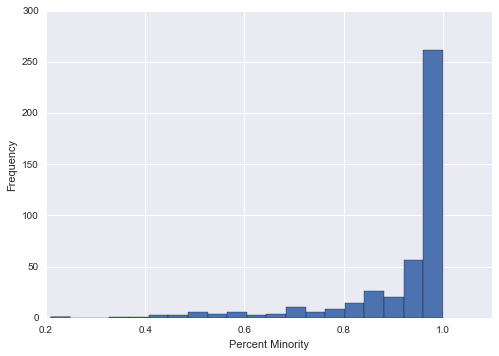

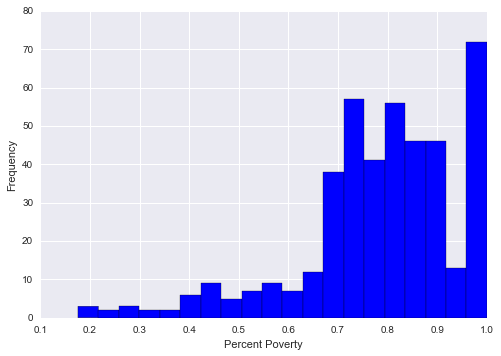

In [9]:
bp_cols_demog = ['PerMinority','PerPoverty']
schoolsN[bp_cols_demog].boxplot(return_type='axes');
plt.show()

schoolsN['PerMinority'].plot.hist(bins=20)
plt.xlabel('Percent Minority')
plt.show()

schoolsN['PerPoverty'].plot.hist(bins=20,color='blue')
plt.xlabel('Percent Poverty')
plt.show()

These plots show that most schools have a very high percentage of minority students (90-100%). However, there is more of a spread of the distribution of percent poverty in the schools, with a mean of around 80% and a larger range of valueus than the percentage of minority students. This gave us some insight on the differences in these variables for when we built our classification models.

###  Data Analysis

#### Objective 1. Multilinear Regression of Factors Important to Students or Parents

Our first objective was to investigate which factors are most important to students versus parents. We used multilinear regression to elucidate the relationships between 'Percent Student Satisfaction' and the factors that had the highest correlation values in our Exploratory Data Analysis section. 

##### Multilinear Regression with Important Factors to Parents

In [10]:
import scipy as sc
from scipy.stats import linregress
from scipy.stats import norm

import statsmodels.formula.api as sm


model = sm.ols(formula="ParentPS ~ FamCommunity_Ties", data=schoolsN)
model_result = model.fit()
print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
print('P-values: \n' + str(model_result.pvalues) + '\n')

#model = sm.ols(formula="ParentPS ~ FamCommunity_Ties + Trust", data=schoolsN)
#model_result = model.fit()
#print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
#print('P-values: \n' + str(model_result.pvalues) + '\n')

#model = sm.ols(formula="ParentPS ~ FamCommunity_Ties + Supportive_Envment", data=schoolsN)
# model_result = model.fit()
# print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
# print('P-values: \n' + str(model_result.pvalues) + '\n')

# model = sm.ols(formula="ParentPS ~ FamCommunity_Ties + School_Leadership", data=schoolsN)
# model_result = model.fit()
# print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
# print('P-values: \n' + str(model_result.pvalues) + '\n')

model = sm.ols(formula="ParentPS ~ School_Leadership + Supportive_Envment + Trust + FamCommunity_Ties",
               data=schoolsN)
model_result = model.fit()
print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
print('P-values: \n' + str(model_result.pvalues) + '\n')

model = sm.ols(formula="ParentPS ~ School_Leadership + Trust + FamCommunity_Ties",
               data=schoolsN)
model_result = model.fit()
print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
print('P-values: \n' + str(model_result.pvalues) + '\n')

ParentPS ~ FamCommunity_Ties R-squared: 0.713746353759
P-values: 
Intercept             2.311686e-67
FamCommunity_Ties    5.898579e-120
dtype: float64

ParentPS ~ School_Leadership + Supportive_Envment + Trust + FamCommunity_Ties R-squared: 0.762958715214
P-values: 
Intercept             1.009879e-19
School_Leadership     6.517901e-10
Supportive_Envment    9.025500e-01
Trust                 1.743682e-15
FamCommunity_Ties     3.651534e-96
dtype: float64

ParentPS ~ School_Leadership + Trust + FamCommunity_Ties R-squared: 0.762950460352
P-values: 
Intercept            1.760006e-20
School_Leadership    5.210792e-10
Trust                1.010185e-17
FamCommunity_Ties    1.176664e-98
dtype: float64



/Users/karajohnson/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'labels' is deprecated. Use 'codes' instead
  if __name__ == '__main__':


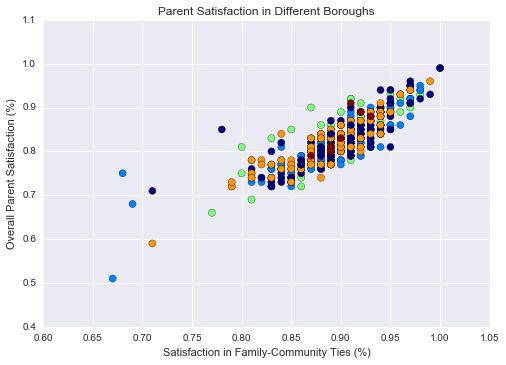

In [11]:
schoolsN['BoroughNum'] = pd.Categorical(schoolsN["Borough"]).labels

plt.scatter(schoolsN['ParentPS'],schoolsN['FamCommunity_Ties'],c=schoolsN['BoroughNum'], s=50, cmap='jet');
plt.xlabel('Satisfaction in Family-Community Ties (%)');
plt.ylabel('Overall Parent Satisfaction (%)');
plt.title('Parent Satisfaction in Different Boroughs') 


##### Multilinear Regression with Important Factors to Students

In [12]:
model = sm.ols(formula="StudentPS ~ Supportive_Envment", data=schoolsN)
model_result = model.fit()
print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
print('P-values: \n' + str(model_result.pvalues) + '\n')

# model = sm.ols(formula="StudentPS ~ Rig_Instruction + Supportive_Envment", data=schoolsN)
# model_result = model.fit()
# print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
# print('P-values: \n' + str(model_result.pvalues) + '\n')

# model = sm.ols(formula="StudentPS ~ PerStudentsSafe + Supportive_Envment", data=schoolsN)
# model_result = model.fit()
# print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
# print('P-values: \n' + str(model_result.pvalues) + '\n')

# model = sm.ols(formula="StudentPS ~ Trust + Supportive_Envment", data=schoolsN)
# model_result = model.fit()
# print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
# print('P-values: \n' + str(model_result.pvalues) + '\n')

# model = sm.ols(formula="StudentPS ~ Collab_Teachers + Supportive_Envment", data=schoolsN)
# model_result = model.fit()
# print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
# print('P-values: \n' + str(model_result.pvalues) + '\n')

model = sm.ols(formula="StudentPS ~ Rig_Instruction + PerStudentsSafe + Trust + Collab_Teachers + Supportive_Envment", data=schoolsN)
model_result = model.fit()
print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
print('P-values: \n' + str(model_result.pvalues) + '\n')

model = sm.ols(formula="StudentPS ~ Trust + Collab_Teachers + Supportive_Envment", data=schoolsN)
model_result = model.fit()
print(str(model.formula) + ' R-squared: ' + str(model_result.rsquared))
print('P-values: \n' + str(model_result.pvalues) + '\n')

StudentPS ~ Supportive_Envment R-squared: 0.959991039711
P-values: 
Intercept              2.114394e-42
Supportive_Envment    1.819267e-305
dtype: float64

StudentPS ~ Rig_Instruction + PerStudentsSafe + Trust + Collab_Teachers + Supportive_Envment R-squared: 0.976308876374
P-values: 
Intercept              3.510849e-15
Rig_Instruction        2.912284e-01
PerStudentsSafe        1.788434e-01
Trust                  6.064047e-12
Collab_Teachers        2.078056e-32
Supportive_Envment    7.559125e-260
dtype: float64

StudentPS ~ Trust + Collab_Teachers + Supportive_Envment R-squared: 0.976138484756
P-values: 
Intercept              3.578356e-15
Trust                  4.350670e-12
Collab_Teachers        3.292533e-44
Supportive_Envment    8.091467e-310
dtype: float64



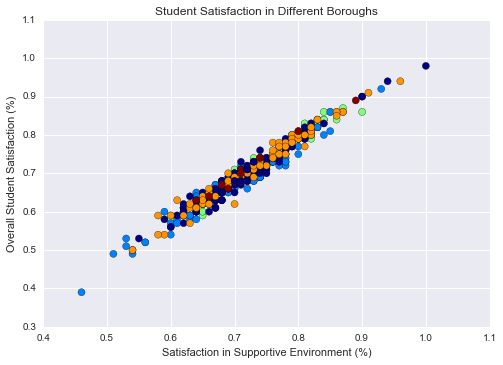

In [13]:
plt.scatter(schoolsN['StudentPS'],schoolsN['Supportive_Envment'],c=schoolsN['BoroughNum'], s=50, cmap='jet');
plt.xlabel('Satisfaction in Supportive Environment (%)');
plt.ylabel('Overall Student Satisfaction (%)');
plt.title('Student Satisfaction in Different Boroughs')
   

##### Multilinear Regression with Difference in Parent and Student Satisfaction

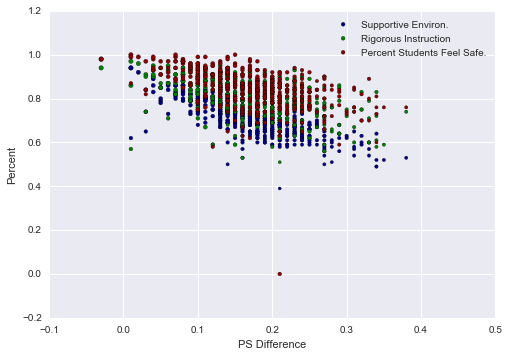

In [14]:
ax = schoolsN.plot.scatter(x='ParentStudentPS_Diff', y='Supportive_Envment', color='DarkBlue', label='Supportive Environ.',s=schoolsN['StudentPS']*20);
schoolsN.plot.scatter(x='ParentStudentPS_Diff', y='Rig_Instruction', color='Green', label='Rigorous Instruction',s=schoolsN['StudentPS']*20,ax=ax);
schoolsN.plot.scatter(x='ParentStudentPS_Diff', y='PerStudentsSafe', color='DarkRed', label='Percent Students Feel Safe.',s=schoolsN['StudentPS']*20,ax=ax);

plt.ylabel('Percent') 
plt.xlabel('PS Difference') 

# SAY SOMETHING

Using the highest correlations with student and parent satisfaction, we were able to generate reasonable multilinear regression models.   
   
For the Parent Percent Satisfaction multilinear regression, the aspects that generated the highest R-squared value were:   
- School Leadership
- Trust
- Family Community Ties   
   
This implies that these three aspects are the factors most important to parents in their child's high school.   
   
For the Student Percent Satisfaction multilinear regression, the aspects that generated the highest R-squared value were:
- Collaborative Teachers
- Trust
- Supportive Environment   
   
This implies that these three aspects are the factors most important to students in their high school.   


#### Objective 2. Classification of Socioeconomics, Demographics, and Borough

We were interested in investigating whether the factors important to students versus parents would be able to correctly classify the schools by their percent poverty, their percent minority, and borough. In order to perform this analysis, we generated classification models using a K-Nearest Neighbors algorithm. We decided on the K-Nearest Neighbors algorithm because when we compared the results to those generated by SVM and Decision Tree, the K-NN generated the most accurate classifications. An example of this comparison is shown in the first section, "Classification of Socioeconomics".   
   
In generating each of these models, we first split the data into training and test data sets (each 0.5 of the total dataset, or 218 schools). We used the training dataset to perform cross-validation in order to pick the best parameters such that our model did not overfit our training data. This was verified by comparing the accuracy of the training versus test datasets for each classification model to ensure that they were not too different.

#### Classification using aspects important to parents:
- School Leadership
- Trust
- Family Community Ties

##### Classification of Socioeconomics (Percent Poverty)

In [16]:
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score, KFold

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

import numpy as np
schoolsN['Borough_bool'] = schoolsN['Borough'].map({'M':0, 'BX':1, 'BK':2, 'Q':3, 'SI':4})

# Define predictor variables 
pred_cols = [10,12,14] 

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['PerPoverty'].as_matrix()
medclass = np.median(class_var)
class_var_bool = class_var > medclass

class_Bool = class_var_bool.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)



##### K-Nearest Neighbors Classification Algorithm

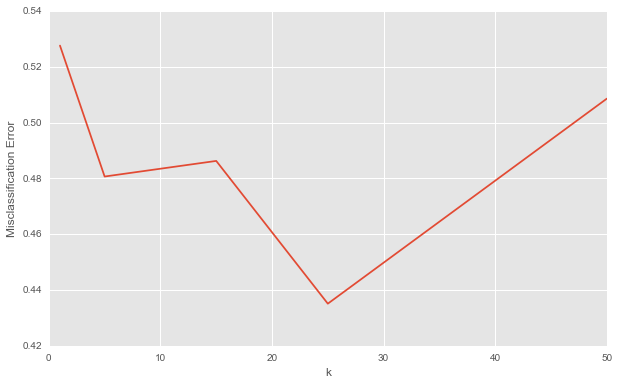

Accuracy on training data =  0.587155963303
Accuracy on test data =  0.545871559633


In [18]:
# 1. K-NN
neighbors = [1, 5, 15, 25, 50]
scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv = cross_val_score(knn, predTrain, classTrain, cv=5, scoring='accuracy')
    scores.append(cv.mean())

error = [1 - s for s in scores]
bestK = neighbors[error.index(min(error))]
plt.plot(neighbors, error)
plt.xlabel('k')
plt.ylabel('Misclassification Error')
plt.show()

k = 25
test1 = KNeighborsClassifier(n_neighbors=k)
test1.fit(predTrain, classTrain)

test_y_pred1 = test1.predict(predTest)
train_y_pred1 = test1.predict(predTrain)

P_Tr_Pov = metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred1)
P_Te_Pov = metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred1)

print('Accuracy on training data = ', P_Tr_Pov)
print('Accuracy on test data = ', P_Te_Pov)

##### SVM Classification Algorithm

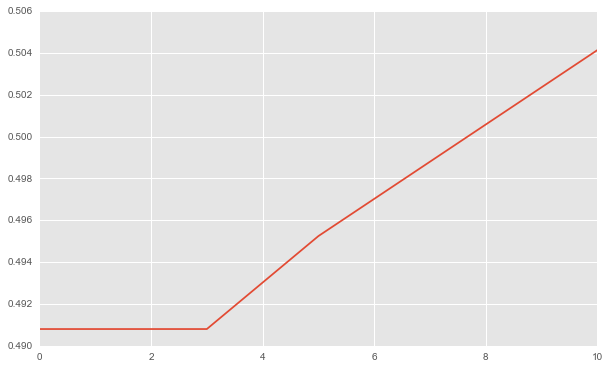

Accuracy on training data=  0.509174311927
Accuracy on test data=  0.490825688073


In [20]:
# 2. SVM

# Cross-validation to choose C
c = [0.01, 0.1, 1, 3, 5, 10]
Cscores = []
for i in c: 
    svm_model = svm.SVC(kernel='rbf', C = i)
    SVMscores = cross_val_score(svm_model, predTrain, classTrain, cv=5, scoring='accuracy')    
    Cscores.append(SVMscores.mean())
        
CError = [1 - t for t in Cscores]

bestC = [CError.index(min(CError))]

plt.plot(c,CError)
plt.show()

# Run and fit the model on the full data
svmX = svm.SVC(kernel='rbf',C=3)
svmX.fit(predTrain, classTrain)

y_train = svmX.predict(predTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = classTrain, y_pred = y_train))

y_test = svmX.predict(predTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = classTest, y_pred = y_test))


##### Decision Tree Classification Algorithm

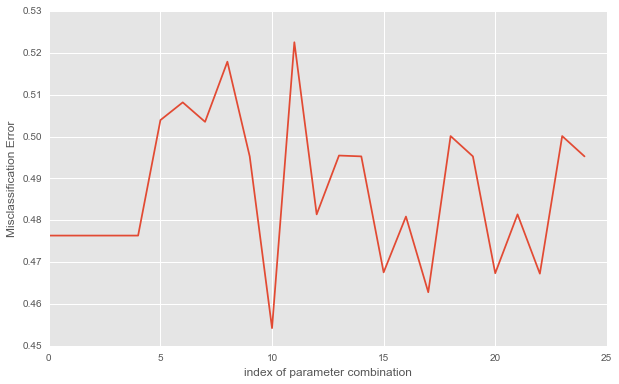

[10]
Accuracy on training data=  0.582568807339
Accuracy on test data=  0.45871559633


In [21]:
# 3. Decision Tree
# Cross-validation to choose max tree depth and minimum samples split
depths = [1, 5,10,25,50]
minSamples = [1, 5, 10, 30, 50]
treeScores = []

for d in depths:
    for minsamp in minSamples:
        decTree = tree.DecisionTreeClassifier(max_depth=d, min_samples_split=minsamp)
        cvs = cross_val_score(decTree, predTrain, classTrain, cv=5, scoring='accuracy')
        treeScores.append(cvs.mean())

treeError = [1 - x for x in treeScores]

bestParam = [treeError.index(min(treeError))]

plt.plot(list(range(len(treeError))), treeError)
plt.xlabel('index of parameter combination')
plt.ylabel('Misclassification Error')
plt.show()
print(bestParam)

decisionTree = tree.DecisionTreeClassifier(max_depth=1, min_samples_split=50)
decisionTree = decisionTree.fit(predTrain, classTrain)

y_pred_train = decisionTree.predict(predTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = classTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(predTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = classTest, y_pred = y_pred))


From these results, the best classification method appears to be the K-Nearest Neighbors method. The SVM algorithm did not generate as accurate of results and the Decision Tree algorithm overfit the training data by approximately 13-14%. We decided to use this method for the remaining classifications for direct comparisons.

##### Classification of Borough

In [23]:
# Define predictor variables 
pred_cols = [10,12,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['Borough_bool'].as_matrix()
class_Bool = class_var.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# 1. K-NN

k = 25
test2 = KNeighborsClassifier(n_neighbors=k)
test2.fit(predTrain, classTrain)

test_y_pred2 = test2.predict(predTest)
train_y_pred2 = test2.predict(predTrain)

P_Tr_Bor = metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred2)
P_Te_Bor = metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred2)

print('Accuracy on training data = ', metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred2))
print('Accuracy on test data = ', metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred2))

Accuracy on training data =  0.353211009174
Accuracy on test data =  0.247706422018


##### Classification of Percent Minority

In [24]:
# Define predictor variables 
pred_cols = [10,12,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['PerMinority'].as_matrix()
medclass = np.median(class_var)
class_var_bool = class_var > medclass

class_Bool = class_var_bool.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# 1. K-NN
neighbors = [1, 5, 15, 25, 50]
scores = []

test = KNeighborsClassifier(n_neighbors=k)
test.fit(predTrain, classTrain)

test_y_pred3 = test.predict(predTest)
train_y_pred3 = test.predict(predTrain)

P_Tr_Min = metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred3)
P_Te_Min = metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred3)

print('Accuracy on training data = ', metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred3))
print('Accuracy on test data = ', metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred3))

Accuracy on training data =  0.564220183486
Accuracy on test data =  0.518348623853


Using the factors most important to parents, the most accurate model was the classification of percent minority.

### Classification Using Important Factors to Students
- Collaborative Teachers
- Trust
- Supportive Environment

#### Classification of Percent Poverty

In [25]:
# Define predictor variables 
pred_cols = [9,13,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['PerPoverty'].as_matrix()
medclass = np.median(class_var)
class_var_bool = class_var > medclass

class_Bool = class_var_bool.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# 1. K-NN

k = 25
test = KNeighborsClassifier(n_neighbors=k)
test.fit(predTrain, classTrain)

test_y_pred4 = test.predict(predTest)
train_y_pred4 = test.predict(predTrain)

S_Tr_Pov = metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred4)
S_Te_Pov = metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred4)

print('Accuracy on training data = ', S_Tr_Pov)
print('Accuracy on test data = ', S_Te_Pov)

Accuracy on training data =  0.56880733945
Accuracy on test data =  0.536697247706


#### Classification of Borough

In [26]:
# Define predictor variables 
pred_cols = [9,13,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['Borough_bool'].as_matrix()

class_Bool = class_var.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# 1. K-NN

k = 25
test = KNeighborsClassifier(n_neighbors=k)
test.fit(predTrain, classTrain)

test_y_pred5 = test.predict(predTest)
train_y_pred5 = test.predict(predTrain)

S_Tr_Bor = metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred5)
S_Te_Bor = metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred5)

print('Accuracy on training data = ', S_Tr_Bor)
print('Accuracy on test data = ', S_Te_Bor)

Accuracy on training data =  0.376146788991
Accuracy on test data =  0.279816513761


#### Classification of Percent Minority

In [27]:
# Define predictor variables 
pred_cols = [9,13,14] # School 
#['Borough', 'NumberPrograms', 'Neighborhood', 'GraduationRate',
#       'AttendanceRate', 'PerStudentsSafe', 'APCourses', 'CTE', 'ParentRR',
#       'Collab_Teachers', 'School_Leadership', 'Rig_Instruction',
#       'FamCommunity_Ties', 'Supportive_Envment', 'Trust', 'ParentPS',
#       'StudentPS', 'TotalEnrollment', 'PerFemale', 'PerMale', 'PerWhite',
#       'PerMinority', 'PerPoverty', 'ParentStudentPS_Diff']

pred_vars = schoolsN[pred_cols].as_matrix()

class_var = schoolsN['PerMinority'].as_matrix()
medclass = np.median(class_var)
class_var_bool = class_var > medclass

class_Bool = class_var_bool.astype(int)

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# 1. K-NN

k = 25
test = KNeighborsClassifier(n_neighbors=k)
test.fit(predTrain, classTrain)

test_y_pred6 = test.predict(predTest)
train_y_pred6 = test.predict(predTrain)

S_Tr_Min = metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred6)
S_Te_Min = metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred6)

print('Accuracy on training data = ', S_Tr_Min)
print('Accuracy on test data = ', S_Te_Min)

Accuracy on training data =  0.614678899083
Accuracy on test data =  0.564220183486


Using the factors most important to students, the most accurate model was the classification of percent minority. Interestingly, the most accurate model using the factors most important to parents was also the classification of minority.

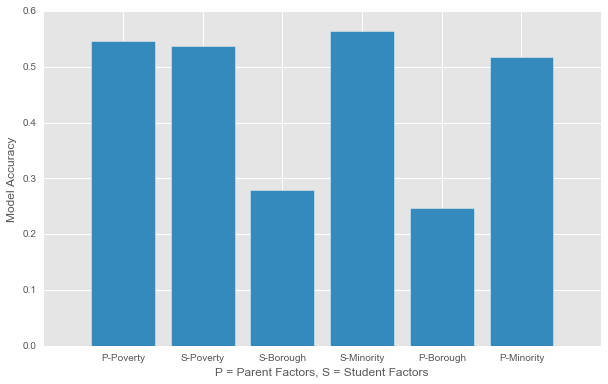

In [28]:
d = {'S-Poverty':S_Te_Pov, 'P-Poverty':P_Te_Pov, 'S-Borough':S_Te_Bor,'P-Borough':P_Te_Bor,
     'S-Minority':S_Te_Min,'P-Minority':P_Te_Min}

plt.bar(range(len(d)), d.values(), align='center');
plt.xticks(range(len(d)), d.keys());
plt.ylabel('Model Accuracy');
plt.xlabel('P = Parent Factors, S = Student Factors');



The above plot shows the accuracy of each of the classification models on the testing dataset. This shows that both the factors important to either students or parents did a poor job of classification of Borough, while the accuracies of these factors classifying the percent minority or percent poverty of the schools were much higher. While these models were not exceptionally accurate (ranging between 50-60%), the factors important to students and parents appear to be more related to the demographic and socioeconomic landscape of the school and less related to the borough to which the school belongs.    
   
Additionally, the student factors yielded more accurate classification models than the parent factors. This seems reasonable because the students more directly and consistently interact with the environment, leadership, and other students at their high school. The most important factors to students (Trust, Collaborative Teachers, and Supportive Environment) are all reflective of their interactions with their peers and teachers. These factors predicted the proportion of minority students and students in poverty better than the factors most important to their parents (School Leadership, Trust, Family-Community Ties).

**Objective 3. Classification of Differences in Student-Parent Percent Satisfaction.**   
   
We classified schools by whether they had a difference in student and parent percent satisfaction of greater than 3 standard deviations of the parent percent satisfaction. If the difference in student-parent percent satisfaction was greated than 3 standard deviations, the school would be considered to have different student and parent satisfaction. The schools with differences in student-parent percent satisfaction less than 3 standard deviations were considered to have relatively similar student and parent satisfaction.   
   
For the predictor variables used to build the model, we used "Rigorous Instruction", "Supportive Environment", and "Percent Students Who Feel Safe" because these variables had the highest correlation to the difference in student-parent percent satisfaction.

0.13945406046516004
PSDiffBool
0    121
1    315
Name: Borough, dtype: int64


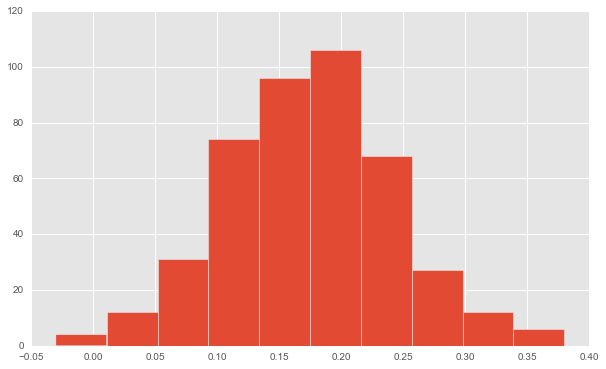

In [31]:
import numpy as np
#find standard deviation of Parent PS 
PPS = schoolsN['ParentPS']
stdPPS = np.std(PPS)
print(3*stdPPS)


#set Parent-Student PS difference to 1 if greater than 2*stdPPS and 0 otherwise

schoolsN['PSDiffBool'] = np.where(schoolsN['ParentStudentPS_Diff'] <=3*stdPPS,0,1)

LargeDiff = schoolsN.groupby('PSDiffBool').count()
print(LargeDiff['Borough'])
schoolsN.head()

plt.hist(schoolsN['ParentStudentPS_Diff']);

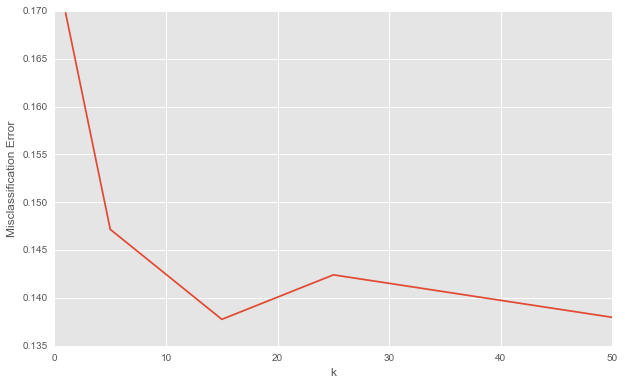

Best K-value:  15
Accuracy on training data =  0.876146788991
Accuracy on test data =  0.862385321101


In [34]:
# Define predictor variables 
pred_cols = ['Rig_Instruction','Supportive_Envment','PerStudentsSafe']

pred_vars = schoolsN[pred_cols].as_matrix()
class_Bool = schoolsN['PSDiffBool']

# Training set
predTrain, predTest, classTrain, classTest = train_test_split(pred_vars, class_Bool, random_state=1, test_size=0.5)

# 1. K-NN
neighbors = [1, 5, 15, 25, 50]
scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv = cross_val_score(knn, predTrain, classTrain, cv=5, scoring='accuracy')
    scores.append(cv.mean())

error = [1 - s for s in scores]
bestK = neighbors[error.index(min(error))]
plt.plot(neighbors, error)
plt.xlabel('k')
plt.ylabel('Misclassification Error')
plt.show()

k = 15
test = KNeighborsClassifier(n_neighbors=k)
test.fit(predTrain, classTrain)

test_y_pred = test.predict(predTest)
train_y_pred = test.predict(predTrain)

print('Best K-value: ', bestK)
print('Accuracy on training data = ', metrics.accuracy_score(y_true = classTrain, y_pred = train_y_pred))
print('Accuracy on test data = ', metrics.accuracy_score(y_true = classTest, y_pred = test_y_pred))



## WRITE SOME KIND OF INTERPRETATION

# SOME KIND OF CONCLUSION.